## Results of Host Prediction
### Dataset: All viruses, all proteins, without duplicates (~19K)

**Models**: Logistic Regression, Random Forest, FNN, CNN, RNN, LSTM, TF

**Positional Embedding**: Sin-Cos

**Maximum Sequence Length**: 1114

**Classification**: Multi-class

**\# classes**: 10

**\# train samples** = 14,633

**\# validation samples** = 1,829

**\# test samples** = 1,830

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/../..']

In [8]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from src.utils import utils, evaluation_utils, visualization_utils

In [30]:
itr_col = "itr"
experiment_col = "experiment"
y_true_col = "y_true"
human_col = "Human"
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['figure.autolayout'] = True


def plot_auprc(auprc_df, metadata, model_name):
    # sort by median
    sorted_median_auprc_df = auprc_df.groupby("class")["auprc"].median().sort_values(ascending=False)
    visualization_utils.pre_plot_config((10, 10))
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    ax = sns.boxplot(data=auprc_df, x="class", y="auprc", order=sorted_median_auprc_df.index)
    
    ax.set_ylim(0, 1)
    ax.set_xticklabels([metadata[t.get_text()] for t in ax.get_xticklabels()])
    ax.set_title(f"Model = {model_name}")
    plt.tight_layout()
    plt.xticks(rotation=-90)
    output_filepath = os.path.join(os.getcwd(), "..","..", "..", "output/visualization/uniref90/20231022/host_multi_val_test_e50/host_multi_tf_class_auprc_boxplot.pdf")
    Path(os.path.dirname(output_filepath)).mkdir(parents=True, exist_ok=True)
    plt.savefig(output_filepath)
    plt.show()
        
def auprc_analysis(output_filepath, model_name):
    df = pd.read_csv(output_filepath, index_col=0)
    print(f"Read output size = {df.shape}")
    cols = df.columns
    non_human_cols = list(set(cols) - set([itr_col, experiment_col, y_true_col, human_col]))
    print(f"NonHuman cols = {non_human_cols}")
    itrs = df[itr_col].unique()
    
    auprc = []
    pr_curves = []
    for itr in itrs:
        df_itr = df[df[itr_col] == itr]
        pr_curves_df, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=non_human_cols + [human_col], y_true_col=y_true_col)
        pr_curves_df[itr_col] = itr
        auprcs_df[itr_col] = itr
        auprc.append(auprcs_df)
        pr_curves.append(pr_curves_df)

    auprc_df = pd.concat(auprc, ignore_index=True)
    pr_curves_df = pd.concat(pr_curves, ignore_index=True)
    
    metadata = utils.compute_class_distribution(df_itr, y_true_col, format=True)
    # Remove Others class
    metadata.pop("Others")
    auprc_df = auprc_df.loc[auprc_df["class"] != "Others"]
    
    plot_auprc(auprc_df, metadata, model_name)
    visualization_utils.curve_plot(pr_curves_df, x_col="recall", y_col="precision",
                                   color_group_col="class", style_group_col=None,
                                   output_file_path=None, metadata=metadata)
    

def auprc_analysis_classes_subset(output_filepaths, classes):
    macro_auprcs = []
    for model, output_filepath in output_filepaths.items():
        df = pd.read_csv(output_filepath, index_col=0)
        print(f"Read output {model} = {df.shape}")
        
        itrs = df[itr_col].unique()
    
        for itr in itrs:
            df_itr = df[df[itr_col] == itr]
            _, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=classes, y_true_col=y_true_col)
            macro_auprcs.append({"model": model,
                                 "itr": itr,
                                 "auprc": auprcs_df["auprc"].mean()})
    macro_auprcs_df = pd.DataFrame(macro_auprcs)

    visualization_utils.pre_plot_config((10, 10))
    ax = sns.boxplot(data=macro_auprcs_df, x="model", y="auprc")
    ax.set_ylim(0, 1)
    ax.set_title(f"Macro AUPRC [Classes = {classes}]")
    plt.tight_layout()
    plt.show()
    

### Logistic Regression

Read output size = (18295, 11)
NonHuman cols = ['Horse', 'Red junglefowl', 'Desert warthog', 'Goat', 'Cattle', 'Lesser bandicoot rat', 'Others', 'Wood mouse']


<Figure size 640x480 with 0 Axes>

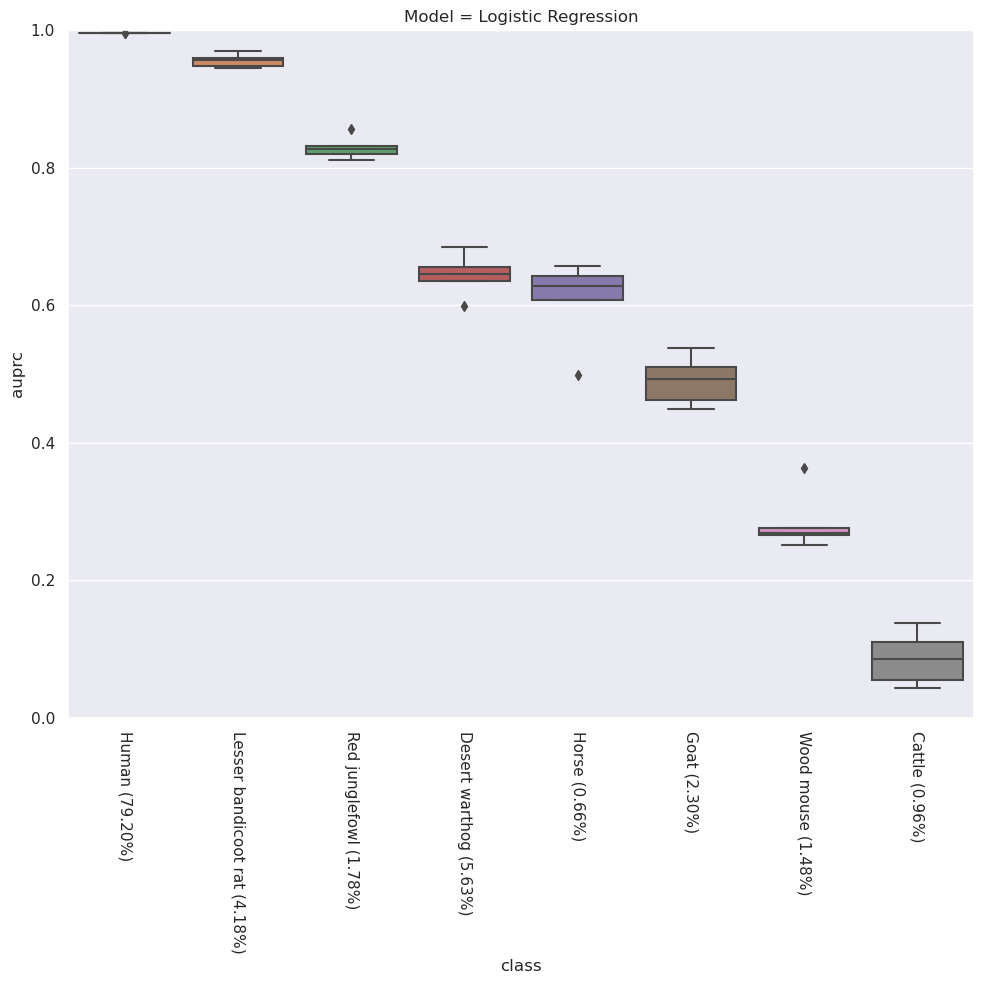

<Figure size 640x480 with 0 Axes>

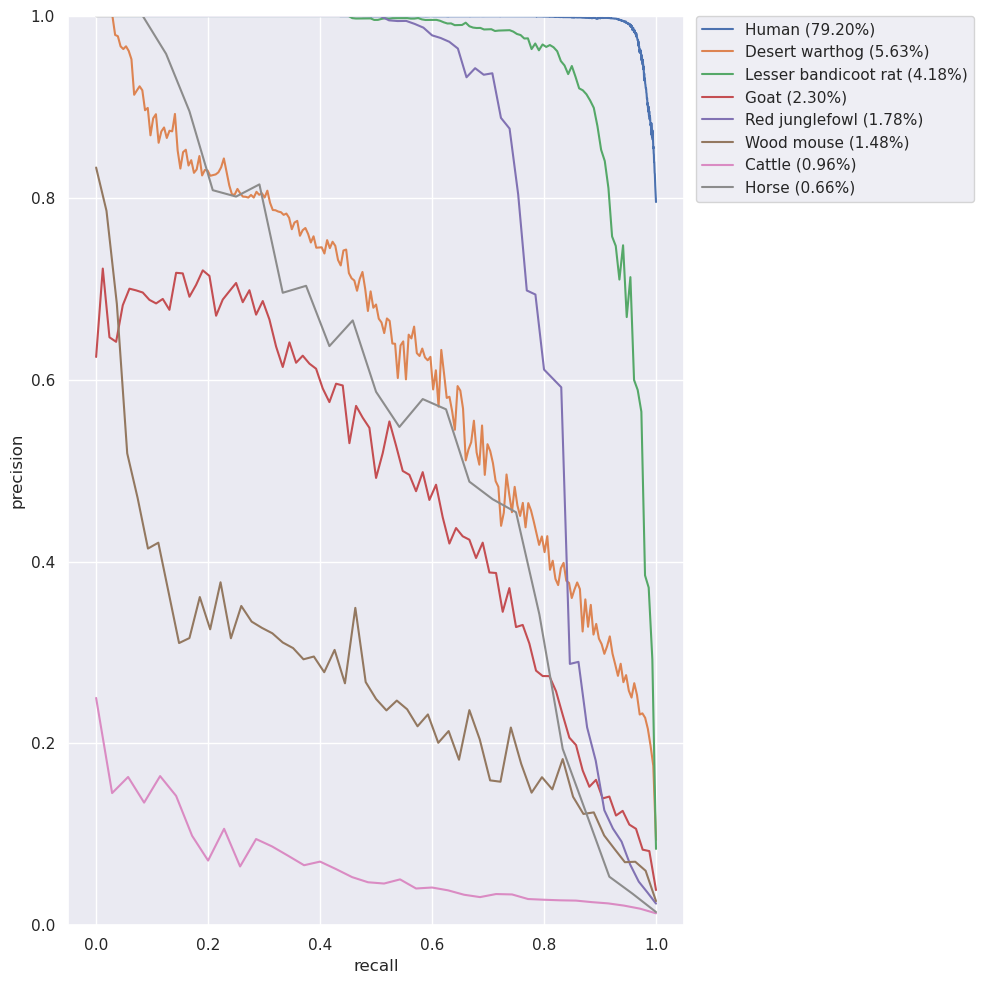

In [4]:
lr_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90/20230705/host_multi_msl1114_baseline/kmer_k3_virus_host_name_multi_kmer_k3-loss_ce__lr_output.csv")
auprc_analysis(lr_output_filepath, "Logistic Regression")

### Random Forest

Read output size = (18295, 11)
NonHuman cols = ['Horse', 'Red junglefowl', 'Desert warthog', 'Goat', 'Cattle', 'Lesser bandicoot rat', 'Others', 'Wood mouse']


<Figure size 640x480 with 0 Axes>

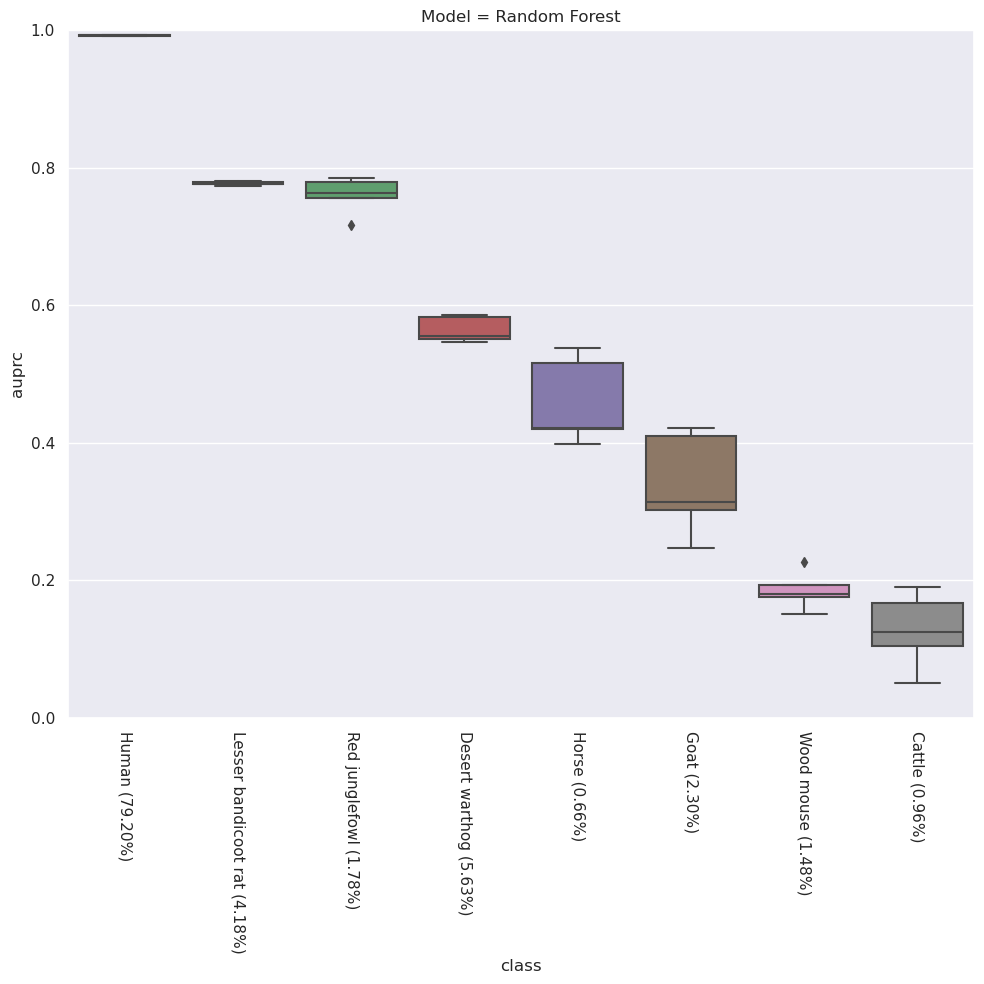

<Figure size 640x480 with 0 Axes>

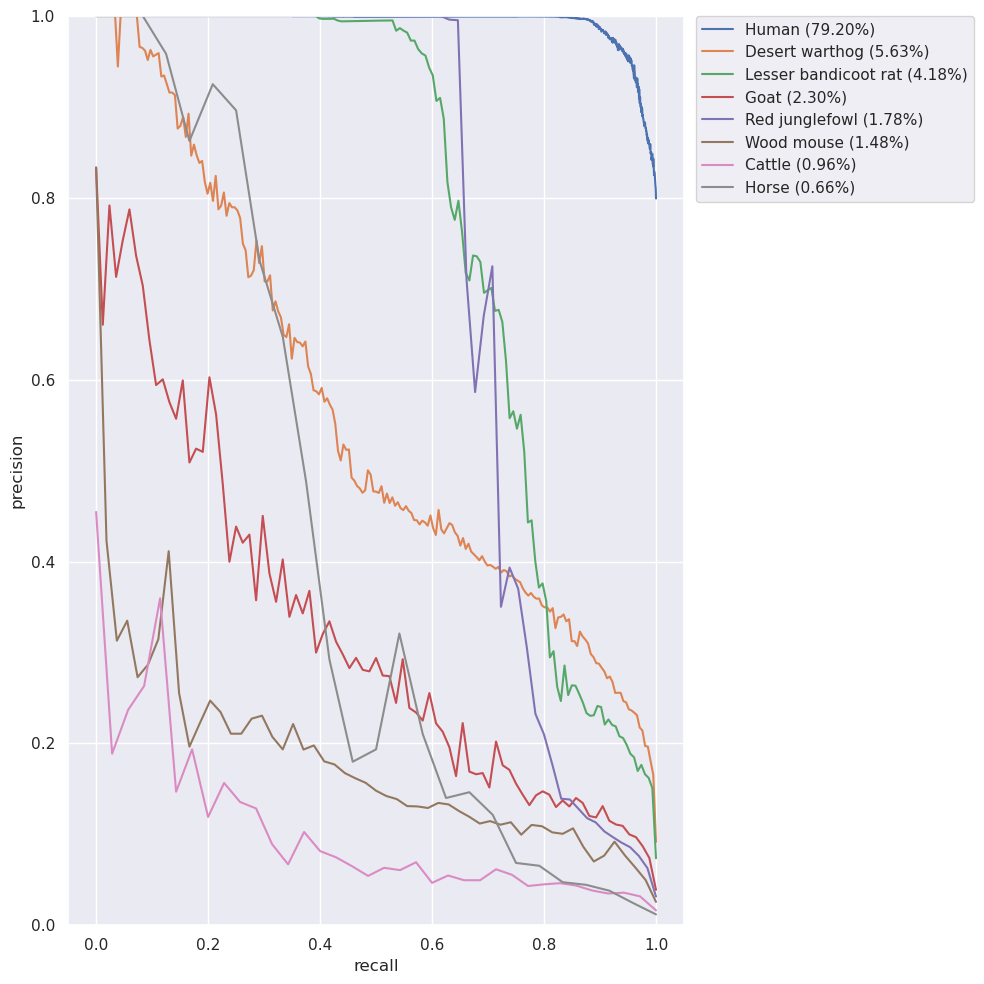

In [5]:
rf_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90/20230705/host_multi_msl1114_baseline/kmer_k3_virus_host_name_multi_kmer_k3-loss_ce__rf_output.csv")
auprc_analysis(rf_output_filepath, "Random Forest")

### FNN

Read output size = (9150, 11)
NonHuman cols = ['Horse', 'Red junglefowl', 'Desert warthog', 'Goat', 'Cattle', 'Lesser bandicoot rat', 'Others', 'Wood mouse']


<Figure size 640x480 with 0 Axes>

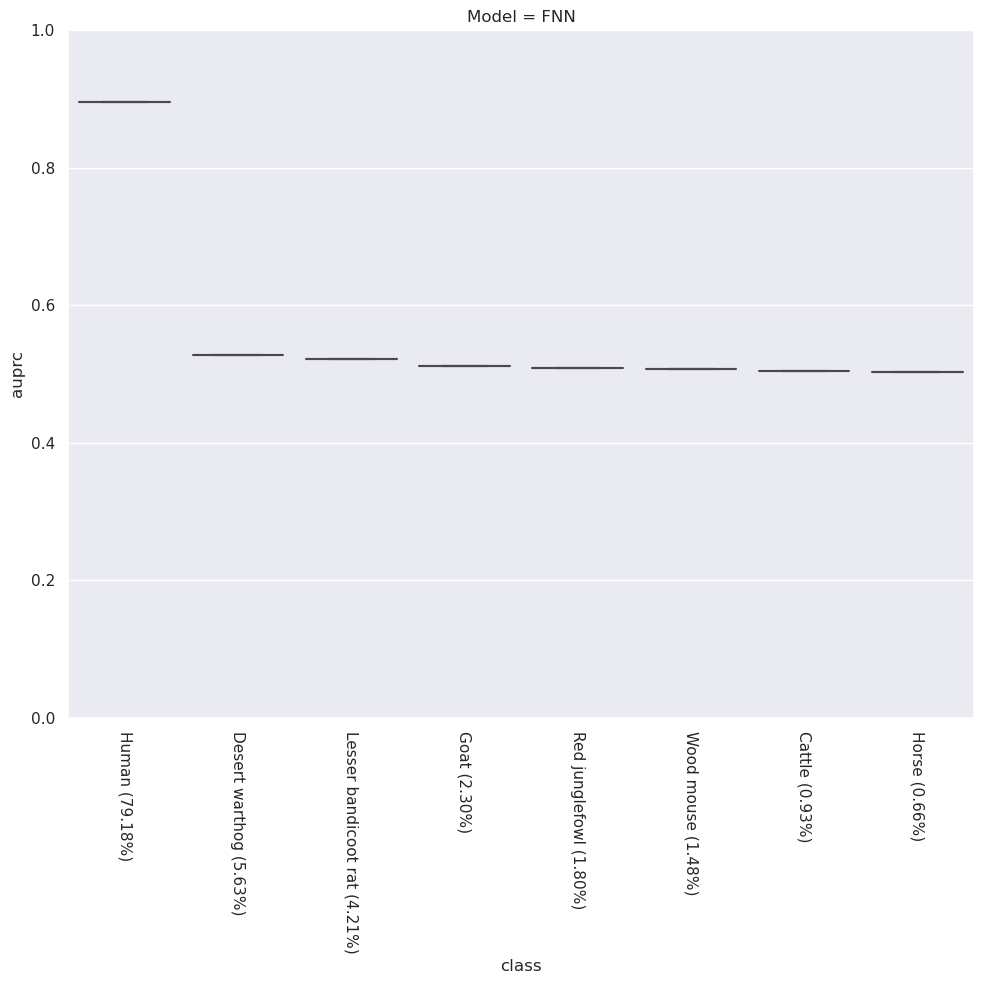

<Figure size 640x480 with 0 Axes>

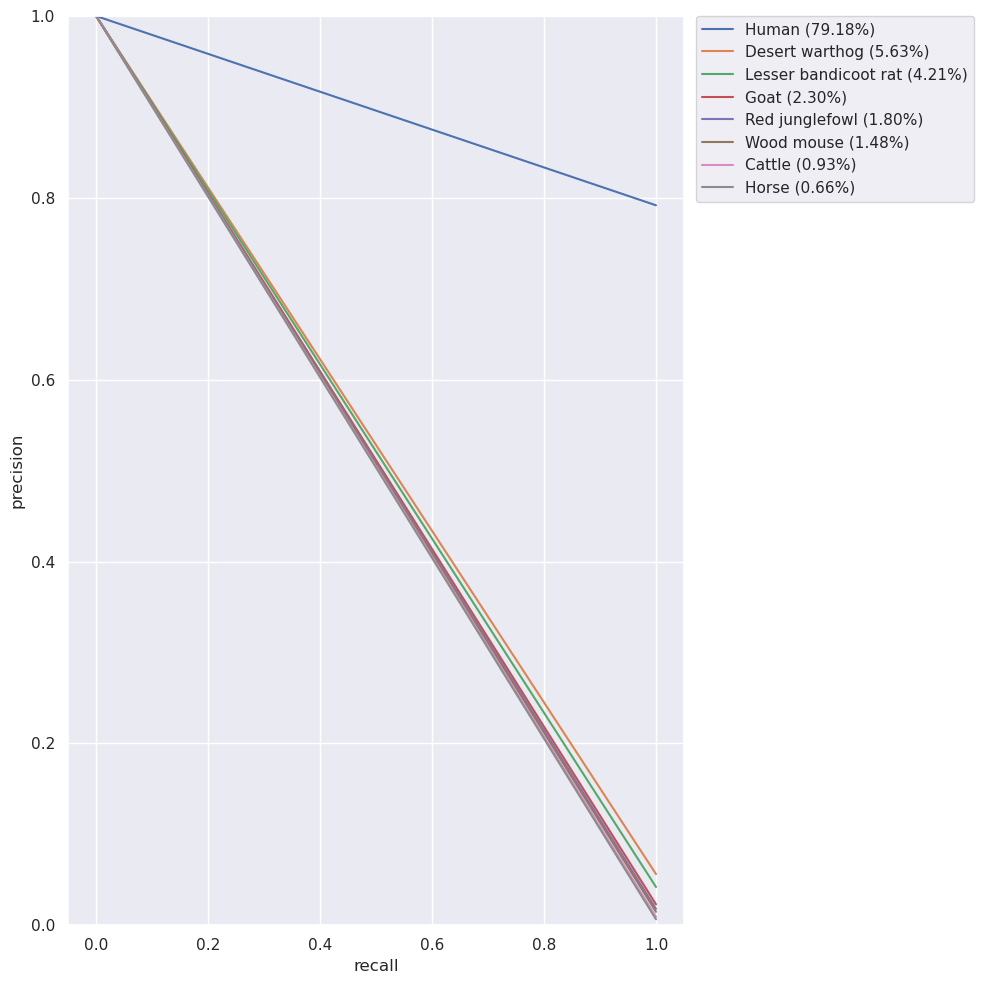

In [6]:
fnn_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90/20230830/host_multi_baseline_focal-lr1e-3-e50-train-val-test/emb_sincos-d_1024-loss_focalce_fnn-l_10-lr1e-3_output.csv")
auprc_analysis(fnn_output_filepath, "FNN")

### RNN

Read output size = (9150, 11)
NonHuman cols = ['Horse', 'Red junglefowl', 'Desert warthog', 'Goat', 'Cattle', 'Lesser bandicoot rat', 'Others', 'Wood mouse']


<Figure size 640x480 with 0 Axes>

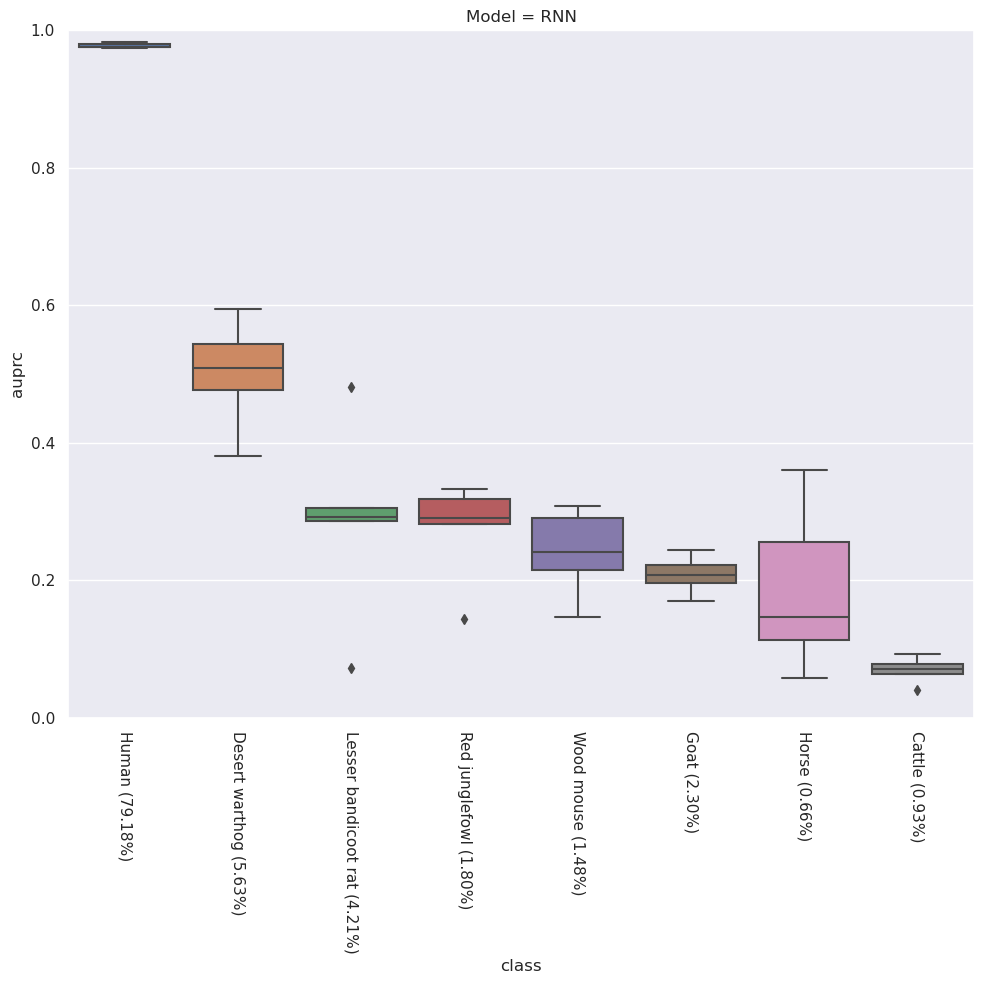

<Figure size 640x480 with 0 Axes>

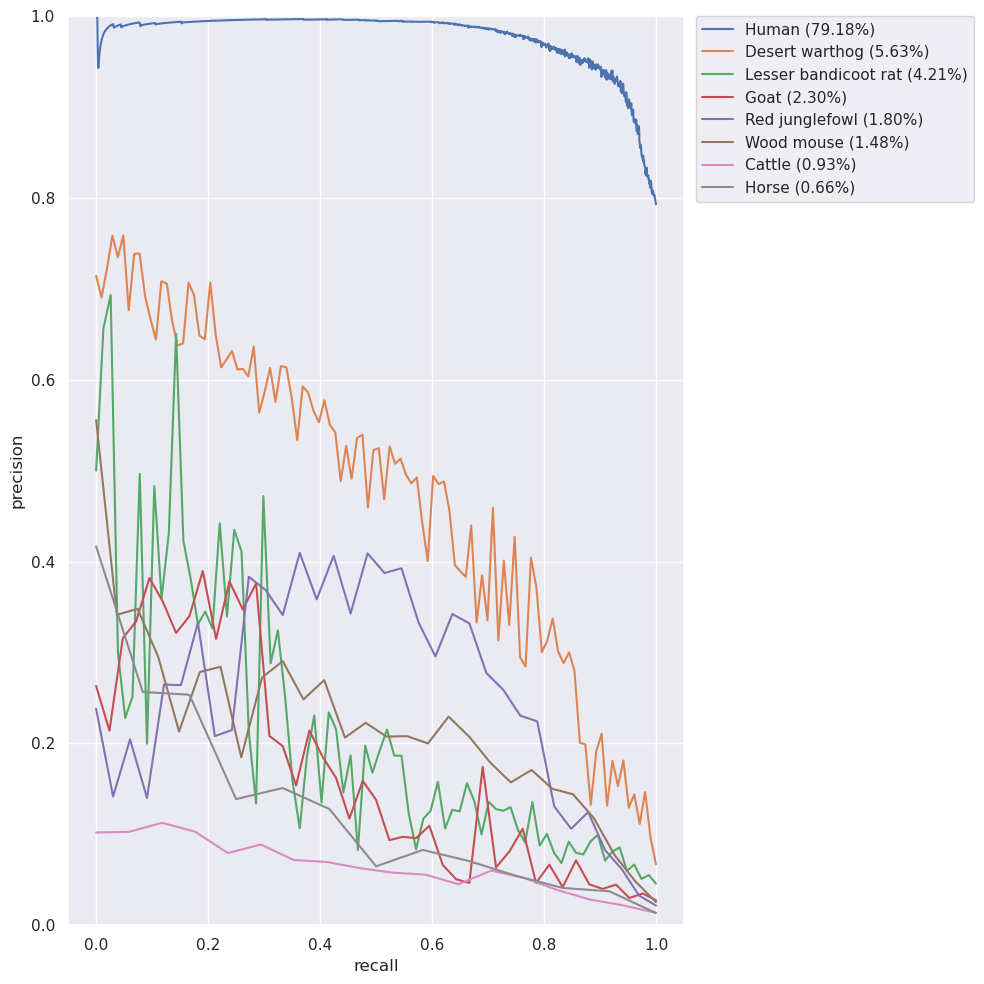

In [7]:
rnn_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90/20230830/host_multi_baseline_focal-lr1e-5-e50-train-val-test/emb_sincos-d_1024-loss_focalce_rnn-l_6-lr1e-5_output.csv")
auprc_analysis(rnn_output_filepath, "RNN")

### CNN

Read output size = (9150, 11)
NonHuman cols = ['Horse', 'Red junglefowl', 'Desert warthog', 'Goat', 'Cattle', 'Lesser bandicoot rat', 'Others', 'Wood mouse']


<Figure size 640x480 with 0 Axes>

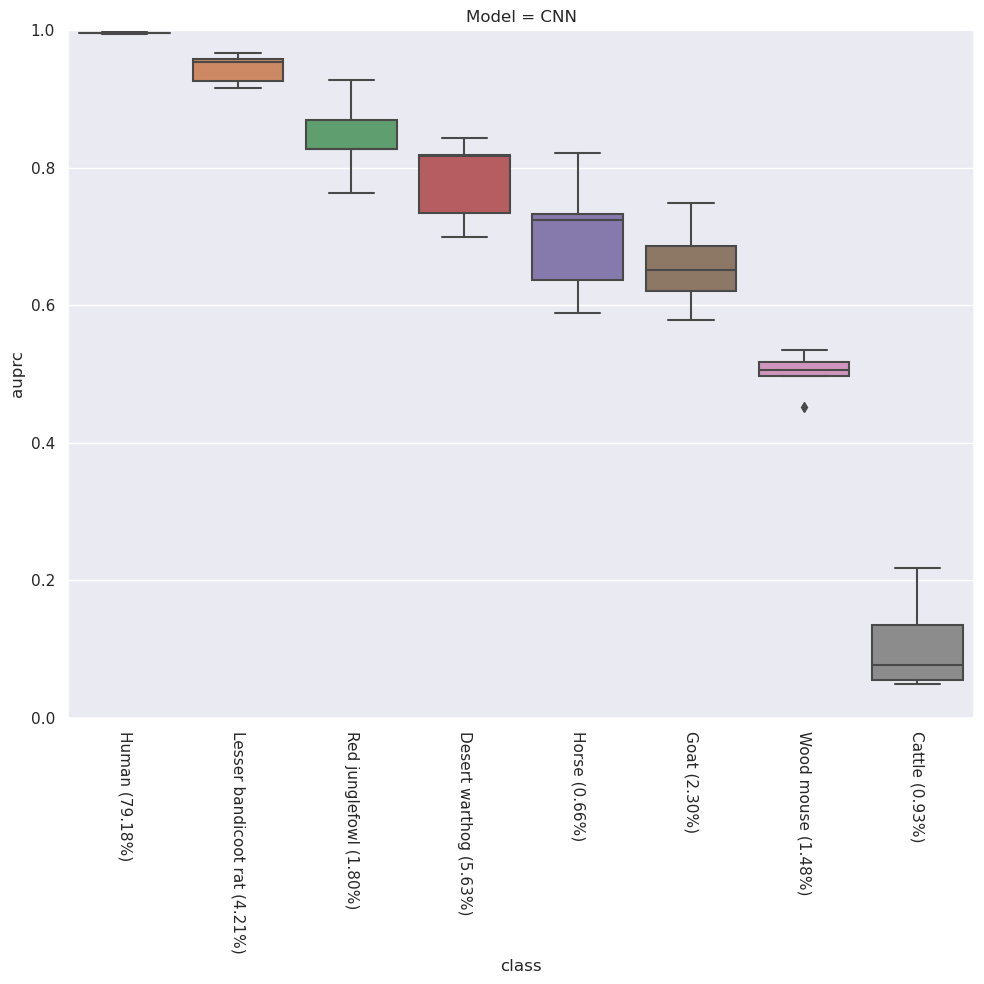

<Figure size 640x480 with 0 Axes>

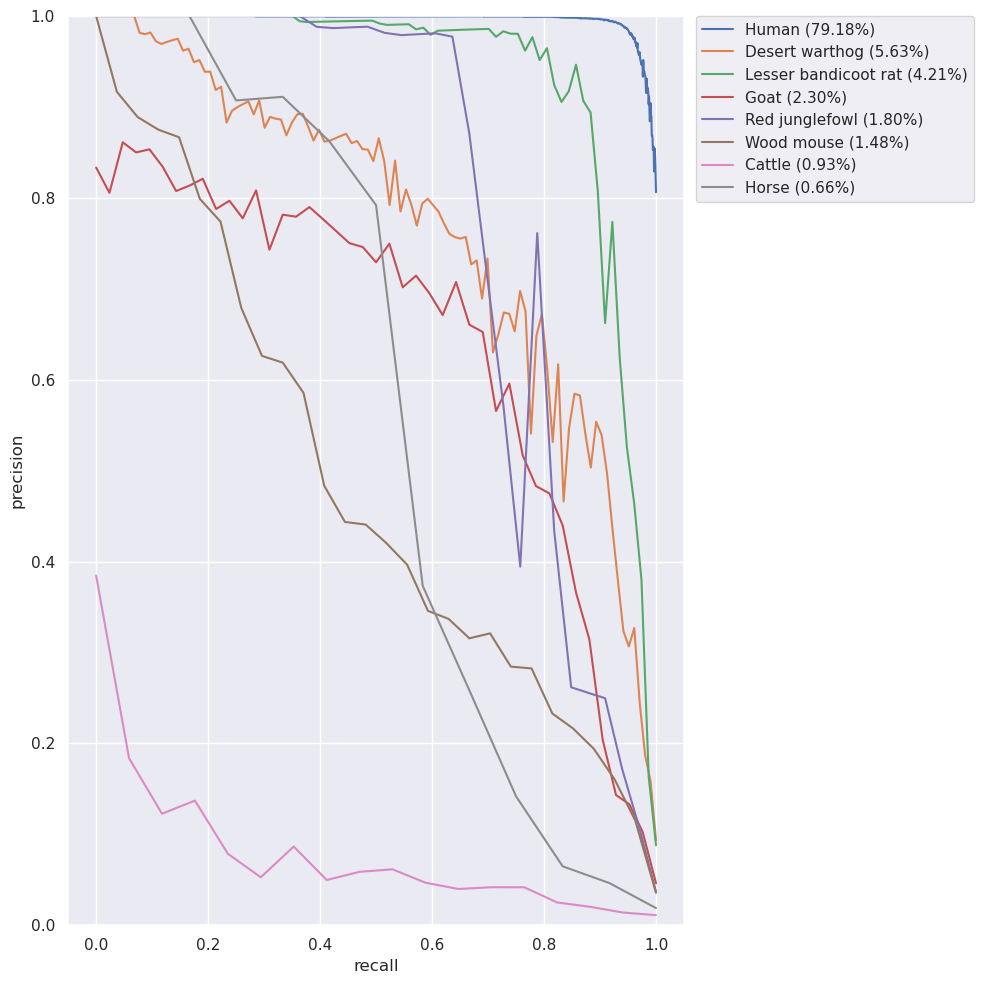

In [8]:
cnn_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90/20230830/host_multi_baseline_focal-lr1e-3-e50-train-val-test/emb_sincos-d_1024-loss_focalce_cnn-l_4-lr1e-3_output.csv")
auprc_analysis(cnn_output_filepath, "CNN")

### LSTM

Read output size = (9150, 11)
NonHuman cols = ['Horse', 'Red junglefowl', 'Desert warthog', 'Goat', 'Cattle', 'Lesser bandicoot rat', 'Others', 'Wood mouse']


<Figure size 640x480 with 0 Axes>

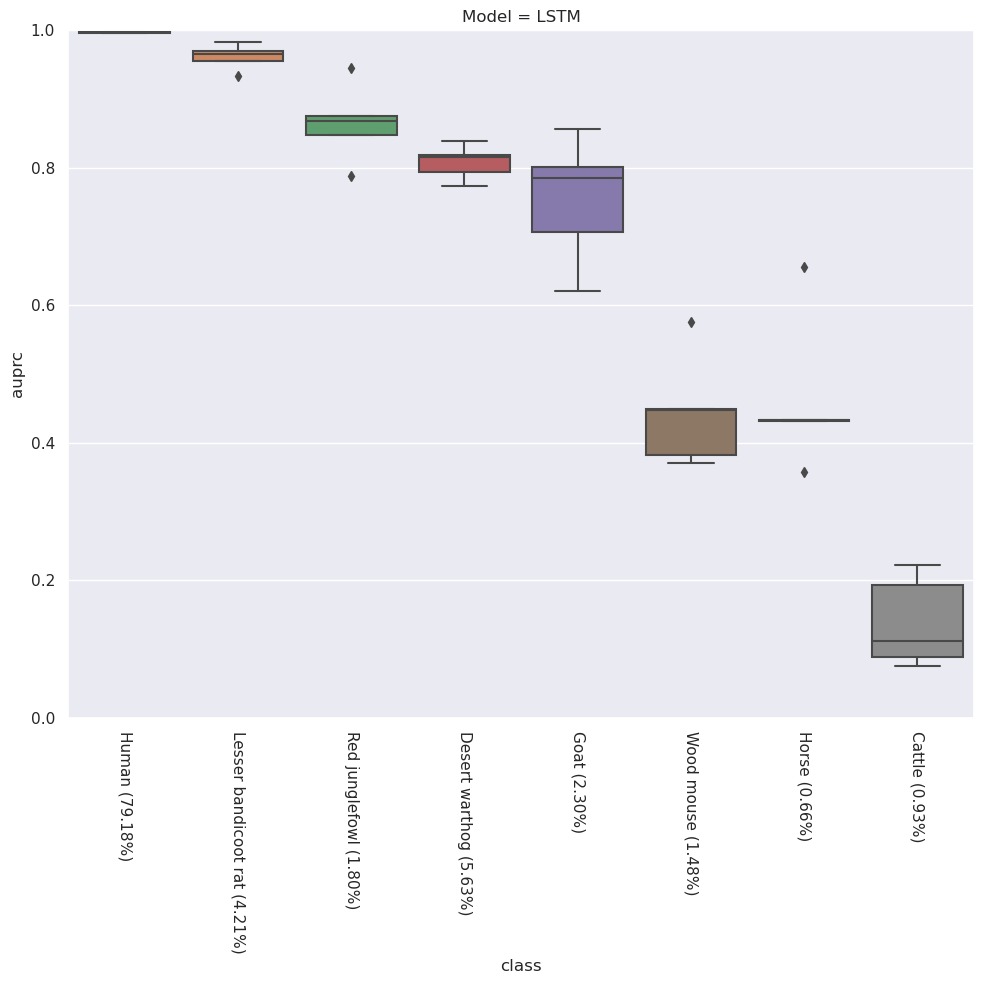

<Figure size 640x480 with 0 Axes>

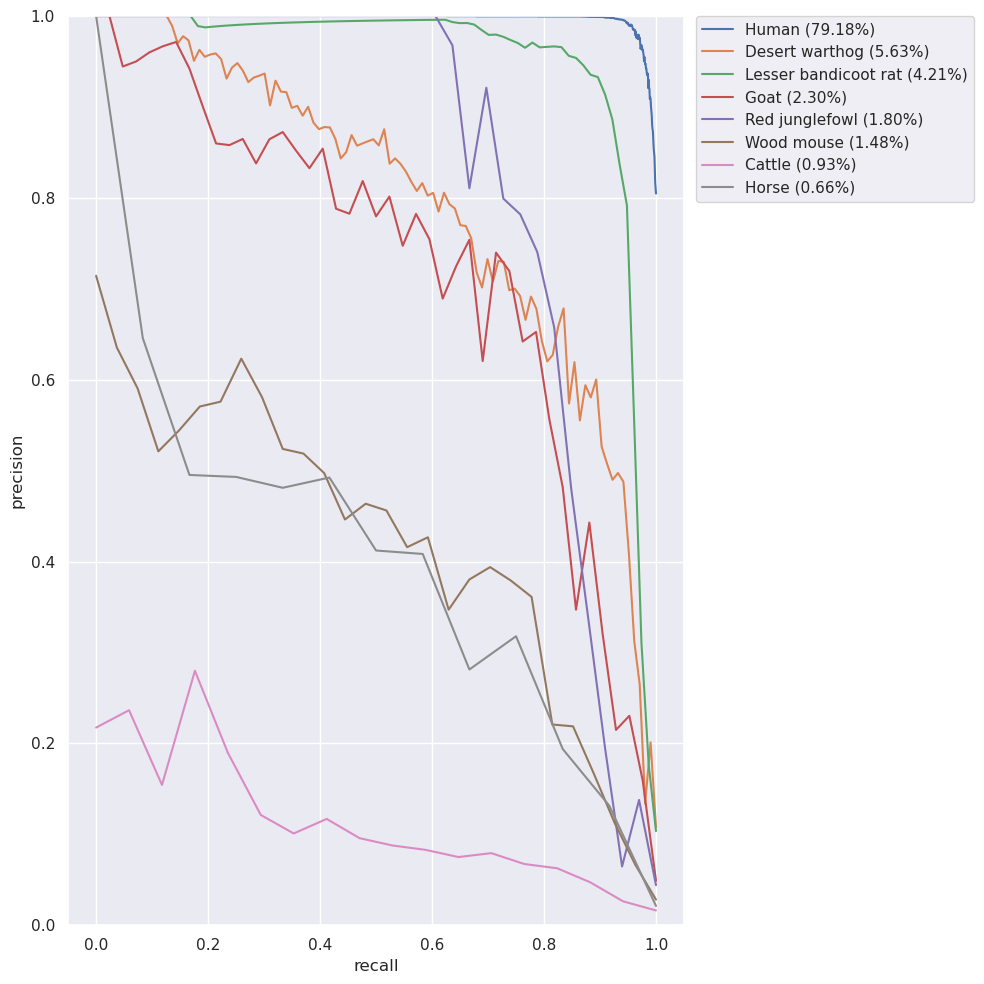

In [9]:
lstm_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90/20230830/host_multi_baseline_focal-lr1e-3-e50-train-val-test/emb_sincos-d_1024-loss_focalce_lstm-l_2-lr1e-3_output.csv")
auprc_analysis(lstm_output_filepath, "LSTM")

### Transformer

Read output size = (9150, 11)
NonHuman cols = ['Wood mouse', 'Lesser bandicoot rat', 'Desert warthog', 'Goat', 'Cattle', 'Horse', 'Red junglefowl', 'Others']


<Figure size 640x480 with 0 Axes>

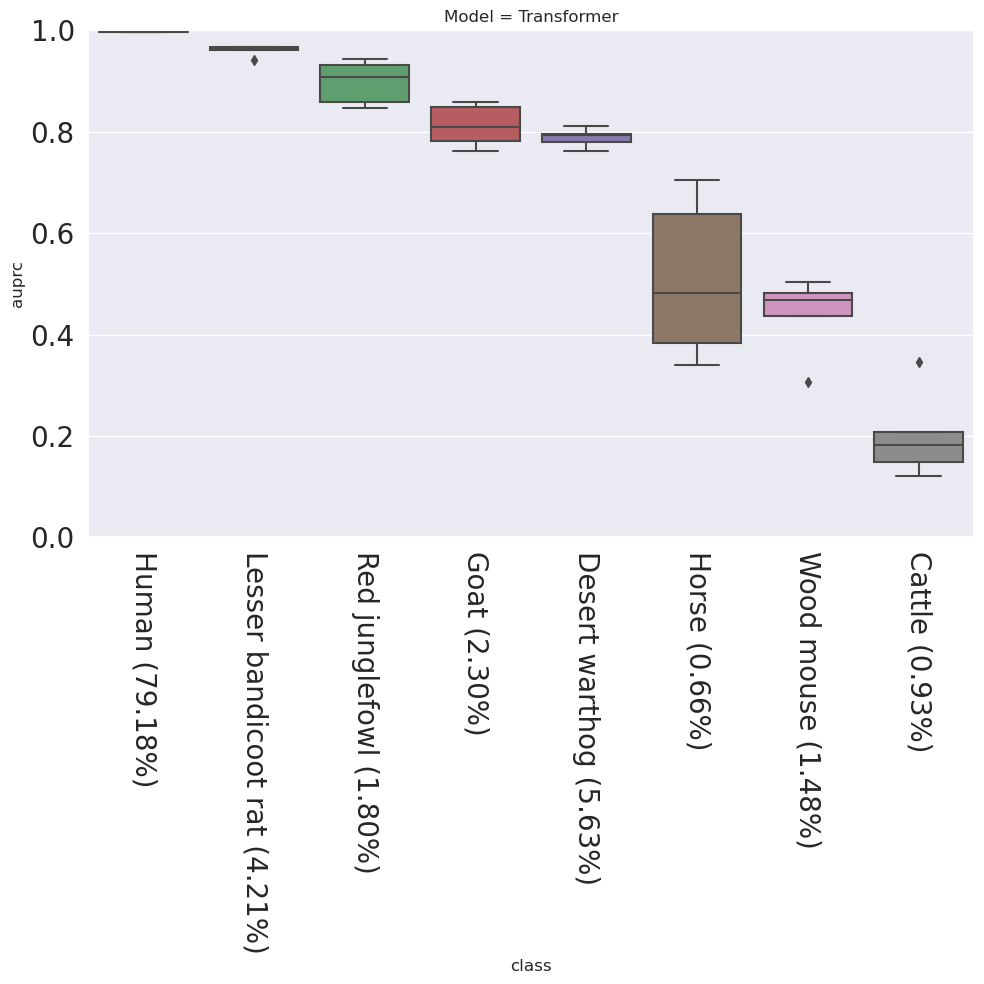

<Figure size 640x480 with 0 Axes>

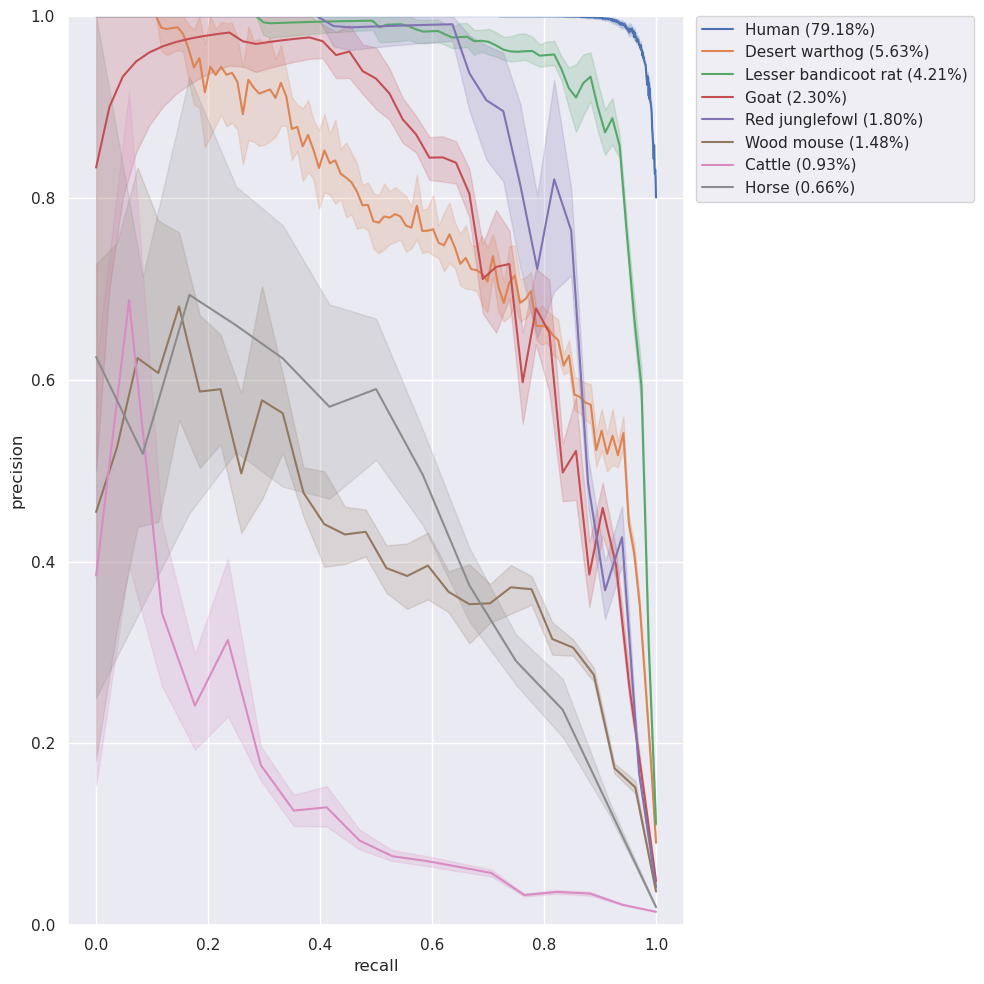

In [29]:
tf_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90/20230830/host_multi_baseline_focal-lr1e-4-e50-train-val-test/emb_sincos-d_1024-loss_focalce_transformer-l_6-h_8-lr1e-4_output.csv")
auprc_analysis(tf_output_filepath, "Transformer")

### Macro AUPRC of all models with selected hosts classes (top 5 from Transformer)

Read output LR = (18295, 11)
Read output RF = (18295, 11)
Read output FNN_10l = (9150, 11)
Read output RNN_6l = (9150, 11)
Read output CNN_4l = (9150, 11)
Read output LSTM_2l = (9150, 11)
Read output TF_6l = (9150, 11)


<Figure size 640x480 with 0 Axes>

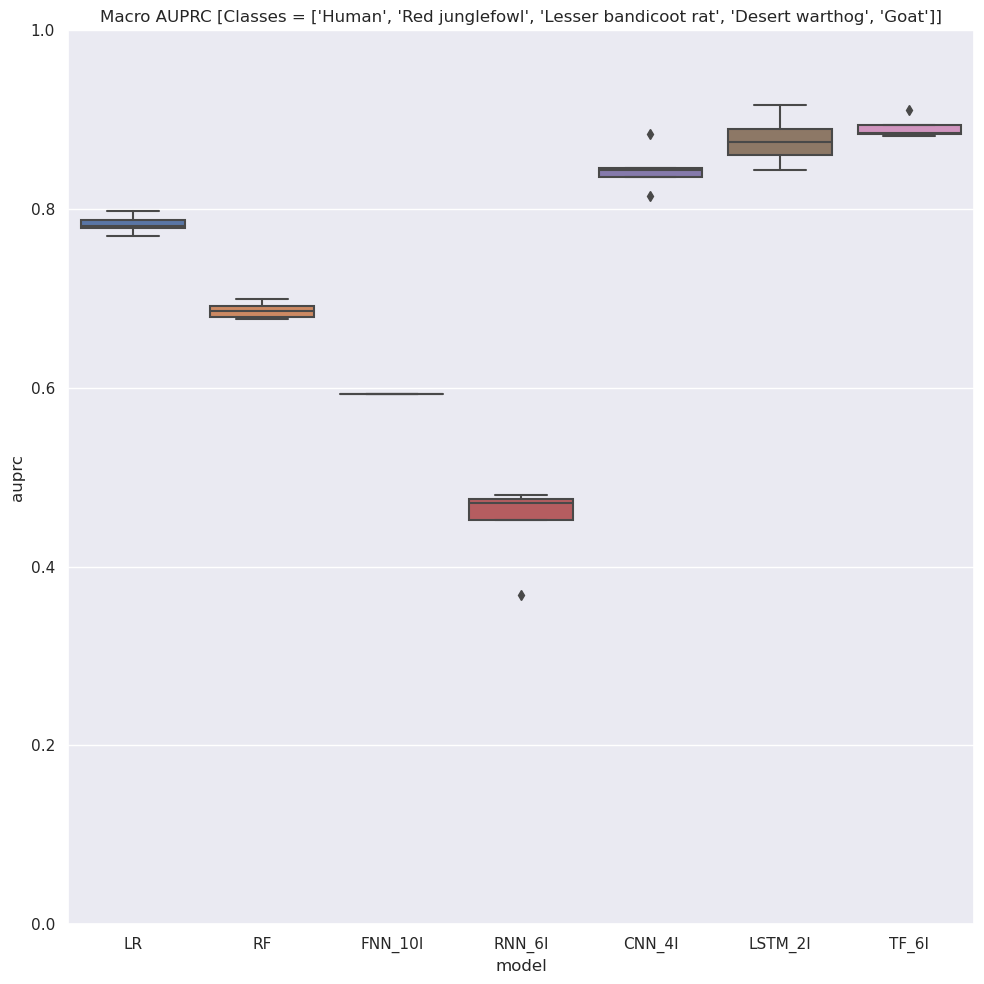

In [11]:
output_filepaths = {
    "LR": lr_output_filepath,
    "RF": rf_output_filepath,
    "FNN_10l": fnn_output_filepath,
    "RNN_6l": rnn_output_filepath,
    "CNN_4l": cnn_output_filepath,
    "LSTM_2l": lstm_output_filepath,
    "TF_6l": tf_output_filepath,
}
classes = ["Human", "Red junglefowl", "Lesser bandicoot rat", "Desert warthog", "Goat"]
auprc_analysis_classes_subset(output_filepaths, classes)